In [1]:
#instalar o pacote
!pip install -q imdb-sqlite

In [2]:
#instalar pacote de codigo de paises
!pip install -q pycountry

In [3]:
#Imports
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [4]:
%%time
!imdb-sqlite

CPU times: total: 0 ns
Wall time: 796 ms


2022-07-25 08:16:16,074 DB already exists: (imdb.db). Refusing to modify. Exiting


In [5]:
conn = sqlite3.connect("imdb.db")

In [6]:
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master where type ='table' ", conn)

In [7]:
type(tabelas)

pandas.core.frame.DataFrame

In [8]:
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [9]:
tabelas = tabelas["Table_Name"].values.tolist()

In [10]:
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela: ", tabela)
    display(resultado)
    print("_" * 100)
    print("\n")

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


____________________________________________________________________________________________________


Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


____________________________________________________________________________________________________


Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


____________________________________________________________________________________________________


Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


____________________________________________________________________________________________________


Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


____________________________________________________________________________________________________


Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


____________________________________________________________________________________________________




# 1 - Quais são as Categorias de Filmes mais Comuns no IMDB?

Quais são os principais tipos(categorias) dos títulosfilme?

In [11]:
consulta_tipos_filmes = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [12]:
tipos_filmes = pd.read_sql_query(consulta_tipos_filmes, conn)

In [13]:
display(tipos_filmes)

,type,COUNT
0,movie,613641
1,short,875943
2,tvEpisode,6784713
3,tvMiniSeries,43986
4,tvMovie,136564
5,tvPilot,2
6,tvSeries,227083
7,tvShort,10580
8,tvSpecial,37428
9,video,262061


In [14]:
tipos_filmes['percentual'] = (tipos_filmes['COUNT'] / tipos_filmes['COUNT'].sum()) * 100

display(tipos_filmes)

,type,COUNT,percentual
0,movie,613641,6.800510
1,short,875943,9.707400
2,tvEpisode,6784713,75.189739
3,tvMiniSeries,43986,0.487463
4,tvMovie,136564,1.513433
5,tvPilot,2,0.000022
6,tvSeries,227083,2.516586
7,tvShort,10580,0.117250
8,tvSpecial,37428,0.414786
9,video,262061,2.904220


In [15]:
others = {}

others['COUNT'] = tipos_filmes[tipos_filmes['percentual'] < 5]['COUNT'].sum()

others['percentual'] = tipos_filmes[tipos_filmes['percentual'] < 5]['percentual'].sum()

others['type'] = 'others'


In [16]:
others

{'COUNT': 749159, 'percentual': 8.302351116911304, 'type': 'others'}

In [17]:
tipos_filmes = tipos_filmes[tipos_filmes['percentual'] > 5]

In [18]:
tipos_filmes = tipos_filmes.append(others,ignore_index=True)

In [19]:
tipos_filmes = tipos_filmes.sort_values(by = 'COUNT', ascending = False)

In [20]:
tipos_filmes.head()

,type,COUNT,percentual
2,tvEpisode,6784713,75.189739
1,short,875943,9.707400
3,others,749159,8.302351
0,movie,613641,6.800510


In [21]:
labes = [str(tipos_filmes['type'][i]) +' '+'['+str(round(tipos_filmes['percentual'][i],2)) + '%'+']' for i in tipos_filmes.index]

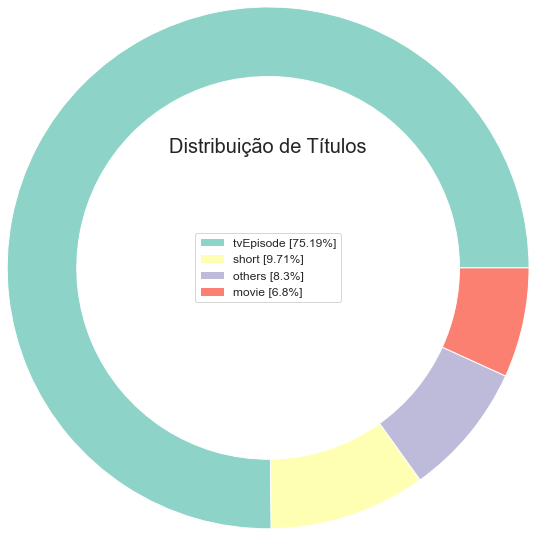

In [22]:
#mapa de cores
cs = cm.Set3(np.arange(100))

#cria figuras
f = plt.figure()

#Pie Plot
plt.pie(tipos_filmes['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labes, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize': 20, 'fontweight': 20})
plt.show()

# 2 - Qual o Número de Títulos por gêneros

In [23]:
consulta_genero = '''SELECT genres, COUNT (*) FROM titles WHERE type ='movie' GROUP BY genres  '''

In [24]:
genero_filme = pd.read_sql_query(consulta_genero, conn)

In [25]:
display(genero_filme)

,genres,COUNT (*)
0,Action,14086
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1462,"Thriller,Western",43
1463,War,1300
1464,"War,Western",14
1465,Western,5122


In [26]:
genero_filme['genres'] = genero_filme['genres'].str.lower().values

In [27]:
temp = genero_filme['genres'].dropna()

In [28]:
padrao = '(?u)\\b[\\w-]+\\b'

vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [29]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [30]:
bag_generos = vetor.transform(temp)

In [31]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [32]:
generos_unicos = vetor.get_feature_names()

In [33]:
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [34]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1467 entries, 0 to 1466
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1467 non-null   int64
 1   adult        1467 non-null   int64
 2   adventure    1467 non-null   int64
 3   animation    1467 non-null   int64
 4   biography    1467 non-null   int64
 5   comedy       1467 non-null   int64
 6   crime        1467 non-null   int64
 7   documentary  1467 non-null   int64
 8   drama        1467 non-null   int64
 9   family       1467 non-null   int64
 10  fantasy      1467 non-null   int64
 11  film-noir    1467 non-null   int64
 12  game-show    1467 non-null   int64
 13  history      1467 non-null   int64
 14  horror       1467 non-null   int64
 15  music        1467 non-null   int64
 16  musical      1467 non-null   int64
 17  mystery      1467 non-null   int64
 18  n            1467 non-null   int64
 19  news         1467 non-null   int64
 20  reality-

In [35]:
generos = generos.drop(columns = 'n', axis = 0)

In [36]:
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending=False) / generos.shape[0]

In [37]:
generos_percentual.head(10)

drama          17.927744
comedy         16.905249
documentary    15.814588
adventure      14.928425
action         14.519427
romance        13.292434
crime          13.019768
mystery        12.406271
thriller       12.269939
horror         12.133606
dtype: float64

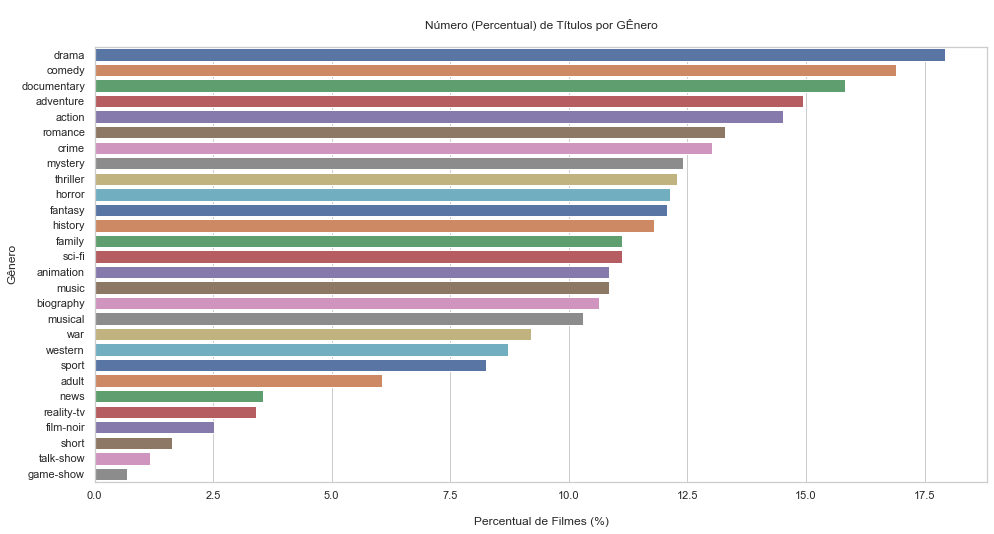

In [38]:
plt.figure(figsize = (16,8))

sns.barplot(x = generos_percentual.values, y = generos_percentual.index , orient="h", palette = "deep")
plt.ylabel('Gênero')
plt.xlabel('\nPercentual de Filmes (%)' )
plt.title('\nNúmero (Percentual) de Títulos por GÊnero\n')
plt.show()

Qual a mediana de Avaliação de Filmes por gênero

In [39]:
consulta_mediana = '''SELECT rating, genres FROM 
                    ratings JOIN titles ON ratings.title_id = titles.title_id
                    WHERE premiered <= 2022 AND type ='movie' '''

In [40]:
medianas_filmes =  pd.read_sql_query(consulta_mediana, conn)

In [41]:
display(medianas_filmes)

,rating,genres
0,4.4,\N
1,6.0,"Action,Adventure,Biography"
2,4.4,Drama
3,4.5,Drama
4,3.9,Drama
...,...,...
279957,5.8,Thriller
279958,6.4,"Drama,History"
279959,3.8,"Adventure,History,War"
279960,8.3,Drama


In [42]:
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [43]:
generos_unicos = retorna_generos(medianas_filmes)

In [44]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [45]:
genero_counts = []
genero_ratings = []

In [46]:
for item in generos_unicos:
    
    #Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta,conn)
    genero_counts.append(resultado.values[0][0])
    
    #Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [47]:
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [48]:
df_genero_ratings.head(20)

,genres,count,rating
0,action,29015,5.8
1,adult,4393,5.8
2,adventure,17577,6.0
3,animation,4806,6.5
4,biography,8546,7.0
5,comedy,69161,6.0
6,crime,23939,6.1
7,documentary,41949,7.3
8,drama,123965,6.3
9,family,10814,6.3


In [49]:
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [50]:
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

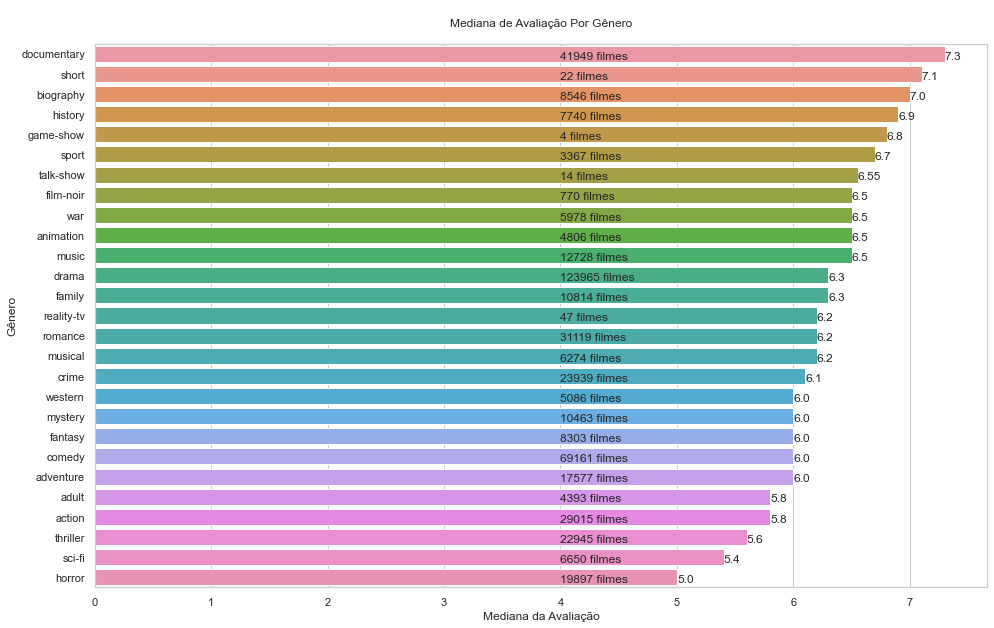

In [51]:
plt.figure(figsize = (16,10))

sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

# Qual a mediana dos filmes por ano de estreia

In [52]:
consulta_mediana = '''SELECT rating AS Rating, premiered FROM 
                    ratings JOIN titles ON ratings.title_id = titles.title_id
                    WHERE premiered <= 2022 AND type ='movie'
                    ORDER BY premiered
                    '''

In [53]:
resultado__mediana_ano = pd.read_sql_query(consulta_mediana,conn)

In [54]:
display(resultado__mediana_ano)

,Rating,premiered
0,6.4,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,5.9,1900
...,...,...
279957,9.4,2022
279958,7.4,2022
279959,6.6,2022
279960,5.0,2022


In [55]:
ratings = []
for year in set(resultado__mediana_ano['premiered']):
    ratings.append(np.median(resultado__mediana_ano[resultado__mediana_ano['premiered'] == year]['Rating']))

In [56]:
ratings[1:10]

[4.5, 3.85, 5.7, 5.85, 3.5, 4.5, 5.3, 4.4, 3.6]

In [57]:
anos = list(set(resultado__mediana_ano['premiered']))

In [58]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

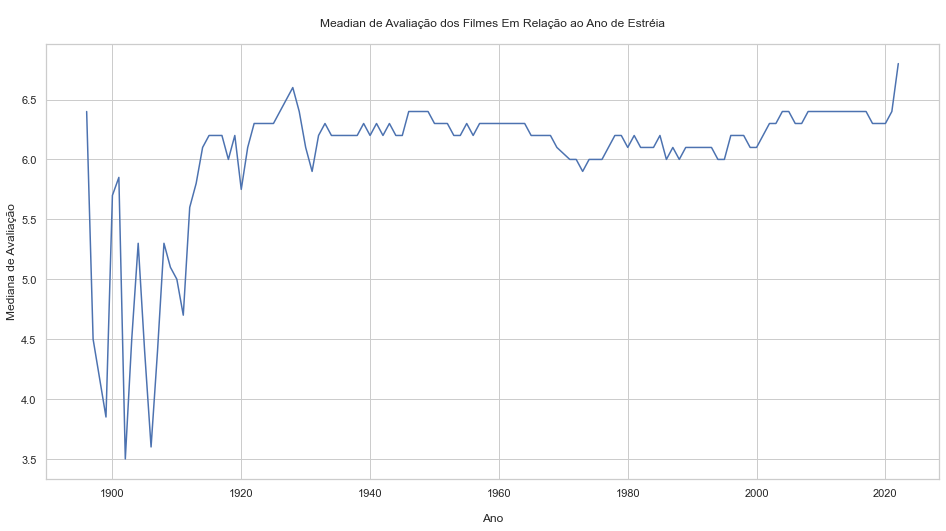

In [59]:
plt.figure(figsize = (16,8))
plt.plot(anos,ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMeadian de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

# 5 - Qual o Número de Filmes Avaliados Por Gêneros Em Relação ao Ano de Estréia?

In [60]:
consulta_genero = '''SELECT genres FROM titles '''

In [61]:
resultado_genero = pd.read_sql_query(consulta_genero, conn)

In [62]:
display(resultado_genero)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
9023451,"Action,Drama,Family"
9023452,"Action,Drama,Family"
9023453,"Action,Drama,Family"
9023454,Short


In [63]:
genero_unicos = retorna_generos(resultado_genero)

In [64]:
genero_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [65]:
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM titles WHERE genres LIKE '+ '\' '+' %'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta,conn)
    genero_count.append(resultado['COUNT'].values[0])

In [66]:
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = genero_unicos
df_genero_count['Count'] = genero_count

In [67]:
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

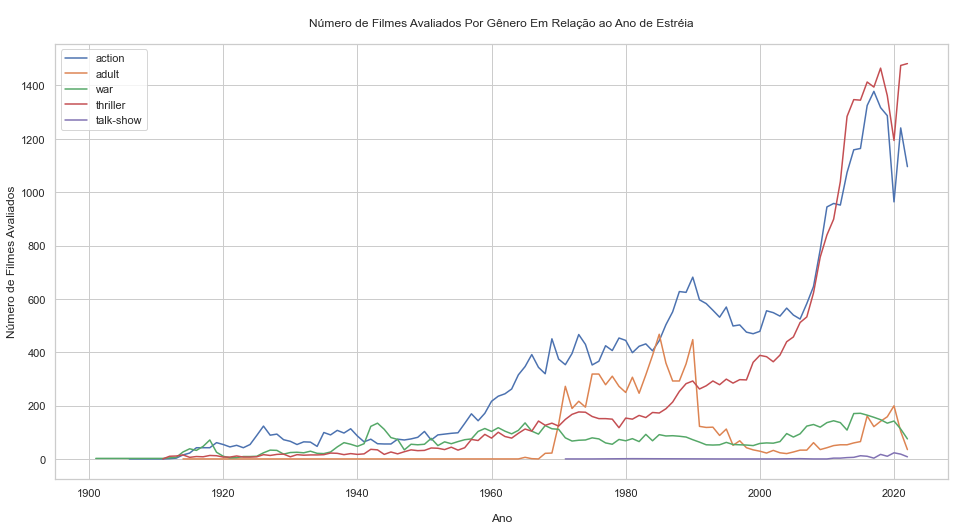

In [68]:
plt.figure(figsize = (16,8))

for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

# 6 - Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.

In [69]:
consulta_tempo_duracao = '''
                         SELECT runtime_minutes Runtime
                         FROM titles
                         WHERE type = 'movie' AND Runtime != 'NaN'
                         '''

In [70]:
resultado_tempo_duracao = pd.read_sql_query(consulta_tempo_duracao, conn)

In [71]:
display(resultado_tempo_duracao)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
386827,123
386828,57
386829,100
386830,116


In [72]:
for i in range(0,101):
    val = i
    perc = round(np.percentile(resultado_tempo_duracao['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val,perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 47.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 51.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 57.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 64.0
18 percentil da duração (runtime) é: 65.0
19 percentil da duração (runtime) é: 67.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 71.0
24 

In [73]:
consulta_maior_tempo = '''
                       SELECT runtime_minutes Runtime, primary_title
                       FROM titles
                       WHERE type = 'movie' AND Runtime != 'NaN'
                       ORDER BY Runtime DESC
                       LIMIT 1
                       '''

In [74]:
consulta_maior_tempo = pd.read_sql_query(consulta_maior_tempo, conn)

In [75]:
display(consulta_maior_tempo)

,Runtime,primary_title
0,51420,Logistics


# 7 - Qual a Relação Entre Duração e Gênero

In [76]:
consulta_duracao_genero = '''
                           SELECT AVG(runtime_minutes) Runtime, genres
                           FROM titles
                           WHERE type = 'movie'
                           AND runtime_minutes != 'NaN'
                           GROUP BY genres
                           '''

In [77]:
resultado_duracao_genero = pd.read_sql_query(consulta_duracao_genero, conn)

In [78]:
generos_unicos = retorna_generos(resultado_duracao_genero)

In [79]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [80]:
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [81]:
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [82]:
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [83]:
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

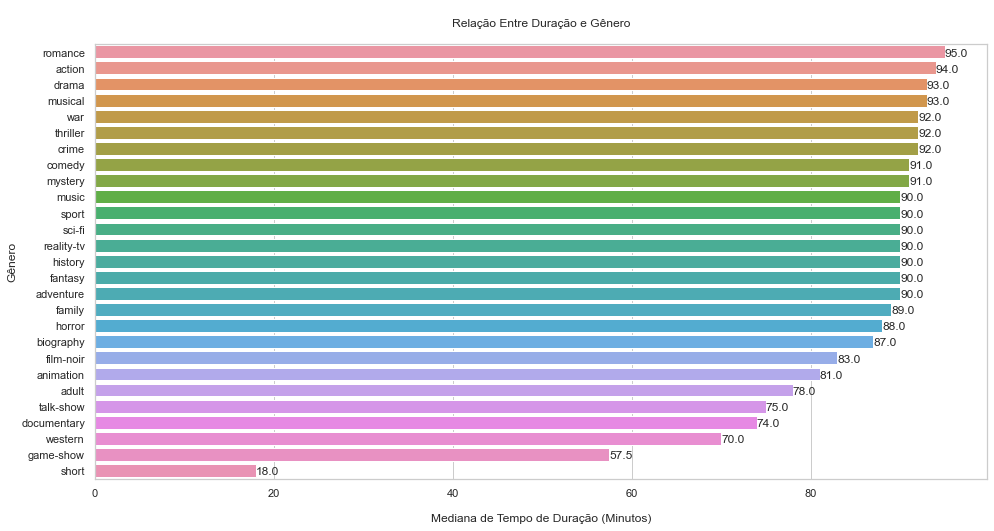

In [84]:
# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

# 8 - Qual o número de Filmes Produzidos Por Pais?

In [85]:
# Consulta SQL
# Consulta SQL
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            ''' 

In [86]:
resultado8 = pd.read_sql_query(consulta8, conn)

In [87]:
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,6805
2,AF,114
3,AG,12
4,AL,1290
...,...,...
229,YUCS,153
230,ZA,3720
231,ZM,15
232,ZRCD,2


In [90]:
resultado8.shape

(234, 2)

In [91]:
resultado8.shape

(234, 2)

In [92]:
nomes_paises = []
contagem = []

In [93]:
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [94]:
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [95]:
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [96]:
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,313933
65,United Kingdom,160471
96,Japan,91928
63,France,85512
89,India,83090
32,Canada,79575
47,Germany,71543
58,Spain,66249
93,Italy,66015
26,Brazil,66012


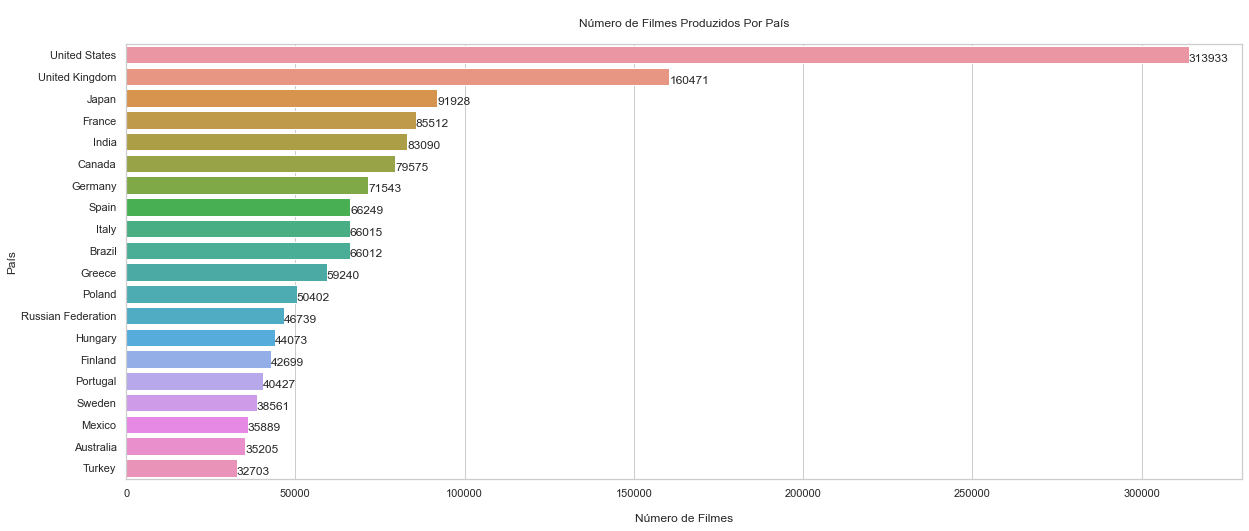

In [97]:
plt.figure(figsize = (20,8))


sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")


for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

# 9 - Quais são os 10 Melhores Filmes?
Com mais de 25 mil votos

In [98]:
consulta_melhores_filmes = '''
                              SELECT primary_title AS Movie_Name, genres, rating
                              FROM 
                              titles JOIN ratings
                              ON  titles.title_id = ratings.title_id
                              WHERE titles.type = 'movie' AND ratings.votes >= 25000
                              ORDER BY rating DESC
                              LIMIT 10    
                           '''

In [100]:
resultado_melhores_filmes = pd.read_sql_query(consulta_melhores_filmes,conn)

In [101]:
display(resultado_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,12 Angry Men,"Crime,Drama",9.0
4,The Godfather Part II,"Crime,Drama",9.0
5,Schindler's List,"Biography,Drama,History",9.0
6,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,Mirror Game,"Crime,Mystery,Thriller",9.0
9,Pulp Fiction,"Crime,Drama",8.9


# 10 - Os 10 piores filmes
Com mais de 25 mil votos

In [102]:
resultado_piores_filmes = '''
                             SELECT primary_title AS Movie_Name, genres, rating
                             FROM 
                             titles JOIN ratings
                             ON  titles.title_id = ratings.title_id
                             WHERE titles.type = 'movie' AND ratings.votes >= 25000
                             ORDER BY rating ASC
                             LIMIT 10
                           ''' 

In [103]:
consulta_piores_filmes = pd.read_sql_query(resultado_piores_filmes, conn)

In [104]:
display(consulta_piores_filmes)

,Movie_Name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,"Crime,Drama,History",1.5
6,Manos: The Hands of Fate,Horror,1.6
7,Justin Bieber: Never Say Never,"Documentary,Music",1.6
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
